In [1]:
!pip install dpt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import dpt
from PIL import Image
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

In [4]:
def findDepth(image_path):
    # Create a DPT feature extractor
    feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")

    # Create a DPT depth estimation model
    model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")
        
    # Specify the path to the image file
    #image_path = image_path

    # Open the image using PIL
    image = Image.open(image_path)
    pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
        
    # Use torch.no_grad() to disable gradient computation
    with torch.no_grad():
        # Pass the pixel values through the model
        outputs = model(pixel_values)
        # Access the predicted depth values from the outputs
        predicted_depth = outputs.predicted_depth
    
    # Interpolate the predicted depth values to the original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    # Normalize predicted depth values
    normalized_depth = (prediction - torch.min(prediction)) / (torch.max(prediction) - torch.min(prediction))
    
    # Apply colormap for visualization (e.g., using matplotlib's viridis colormap)
    colormap = plt.cm.viridis
    colored_depth = (colormap(normalized_depth.cpu().numpy()) * 255).astype(np.uint8)
    
    # Convert colored depth array to PIL image
    colored_depth_image = Image.fromarray(colored_depth[:, :, :3])  # Ensure only RGB channels
    
    return colored_depth_image

E:\Supporting Tools\Python\Lib\site-packages\transformers\models\dpt\feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


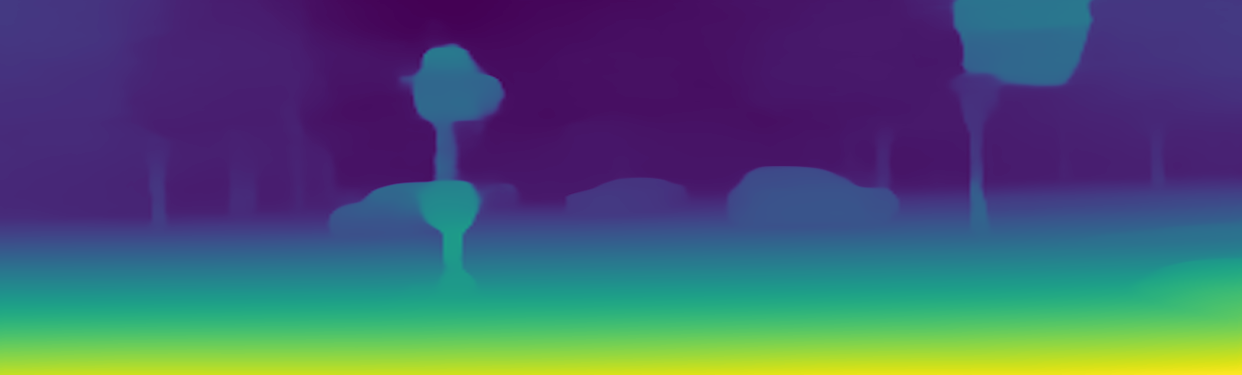

In [5]:
img=findDepth("testing/000010_10.png")
img

In [6]:
img.save('depthMap.png')